In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import h3
import time
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
# from keras.models import Sequential
# from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder, StandardScaler
from prettytable import PrettyTable
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
%matplotlib inline

# pd.set_option("display.max_columns",None)

import warnings
warnings.filterwarnings("ignore")

In [81]:
merged_df = pd.read_csv('/Users/JohnnyBlaze/data/merged.csv', low_memory=False)

In [82]:
merged_df = merged_df.copy()

In [83]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42289 entries, 0 to 42288
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   STATION                   42289 non-null  object 
 1   LATITUDE                  42289 non-null  float64
 2   LONGITUDE                 42289 non-null  float64
 3   ELEVATION                 42289 non-null  float64
 4   NAME                      42289 non-null  object 
 5   CDSD                      39981 non-null  float64
 6   CDSD_ATTRIBUTES           39577 non-null  object 
 7   CLDD                      42241 non-null  float64
 8   CLDD_ATTRIBUTES           42241 non-null  object 
 9   DT00                      42279 non-null  float64
 10  DT00_ATTRIBUTES           42279 non-null  object 
 11  DT32                      42279 non-null  float64
 12  DT32_ATTRIBUTES           42279 non-null  object 
 13  DX32                      42270 non-null  float64
 14  DX32_A

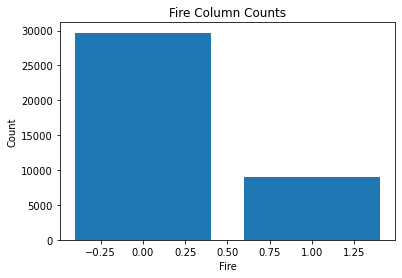

0.0    29695
1.0     8988
Name: fire, dtype: int64


In [95]:
# Check if there's class imbalance, will deal with later

# Count the number of 1's and 0's in the fire column
counts = merged_df['fire'].value_counts()

# Create bar graph
plt.bar(counts.index, counts.values)
plt.title("Fire Column Counts")
plt.xlabel("Fire")
plt.ylabel("Count")
plt.show()

print(counts)

In [84]:
# % of NULLS

# Compute the percentage of null values in each column
null_percentages = (merged_df.isnull().sum() / len(merged_df)) * 100

# Set the option to display all rows and columns
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Round the values to 2 decimal places and add a percent symbol
null_percentages = null_percentages.round(2).astype(str) + '%'

# Sort the values in descending order
null_percentages = null_percentages.sort_values(ascending=False)

# Print the results
print(null_percentages)

FinalAcres                  99.99%
PredominantFuelModel        99.93%
FireCauseGeneral             99.9%
POOCity                     99.74%
FireBehaviorGeneral3        99.73%
FireBehaviorGeneral2        99.68%
IncidentShortDescription    99.67%
FireBehaviorGeneral1        99.65%
PrimaryFuelModel            99.61%
FireBehaviorGeneral         99.61%
EstimatedCostToDate         99.57%
ContainmentDateTime         89.05%
ControlDateTime              88.9%
FireOutDateTime              87.4%
IsTrespass                  83.72%
DiscoveryAcres              78.62%
GACC                         77.0%
POOState                    76.99%
IncidentName                76.99%
FireCause                   76.99%
InitialLatitude             76.99%
InitialLongitude            76.99%
FireDiscoveryDateTime       76.99%
ym_date                     76.99%
PRESNFCD                    65.25%
CDSD_ATTRIBUTES              6.41%
CDSD                         5.46%
HDSD_ATTRIBUTES              5.22%
STDAGE              

In [85]:
# Drop columns with more than 75% null values
threshold = 75.0
null_percentages = null_percentages.str.rstrip('%').astype('float')
cols_to_drop = null_percentages[null_percentages > threshold].index.tolist()
merged_df.drop(columns=cols_to_drop, inplace=True)

In [86]:
# Identify Columns to Used

ignore_cols = ['STATION', 'LATITUDE', 'LONGITUDE', 'NAME', 'geohash', 'year', 'month', 'PLT_CN',
               'STATE', 'LAT', 'LON']

categorical_cols = ['CDSD_ATTRIBUTES', 'CLDD_ATTRIBUTES', 'DT00_ATTRIBUTES', 'DT32_ATTRIBUTES',
                    'DX32_ATTRIBUTES', 'DX70_ATTRIBUTES', 'DX90_ATTRIBUTES', 'HDSD_ATTRIBUTES', 
                    'HTDD_ATTRIBUTES', 'TAVG_ATTRIBUTES', 'TMAX_ATTRIBUTES', 'TMIN_ATTRIBUTES']

# These categorical columns have many, many columns will take out
categorical_cols_large = ['EMNT_ATTRIBUTES', 'EMXT_ATTRIBUTES']

numerical_cols = ['ELEVATION', 'CDSD', 'CLDD', 'DT00', 'DT32', 'DX32', 'DX70','DX90',
                  'EMNT', 'EMXT', 'HDSD', 'HTDD', 'TAVG', 'TMAX', 'TMIN', 'MAPDEN',
                  'STDAGE', 'STDSZCD', 'FLDSZCD', 'SITECLCD', 'SICOND', 'STDORGCD',
                  'SLOPE', 'PHYSCLCD', 'GSSTKCD', 'DSTRBCD1', 'TRTCD1', 'PRESNFCD',
                  'FLDAGE', 'CARBON_DOWN_DEAD', 'CARBON_LITTER', 'CARBON_SOIL_ORG',
                  'CARBON_STANDING_DEAD', 'CARBON_UNDERSTORY_AG', 'CARBON_UNDERSTORY_BG',
                  'WATERCD', 'COND_STATUS_CD']

target_col = ['fire']

In [87]:
# Impute Missing Numerical Values

# Create an instance of the iterative imputer
imputer = IterativeImputer()

# Fit and transform the imputer on the columns to impute
merged_df[numerical_cols] = imputer.fit_transform(merged_df[numerical_cols])

In [88]:
# Loop through the columns and print distinct values from categorical col
cat_cols = []
for col in merged_df.columns:
    if col in categorical_cols_large or col in categorical_cols:
        if merged_df[col].dtype == 'object' or merged_df[col].dtype.name == 'category':
            cat_cols.append(col)
            print(f"Distinct values in {col}: {merged_df[col].unique()}")

Distinct values in CDSD_ATTRIBUTES: [nan 'U']
Distinct values in CLDD_ATTRIBUTES: [',U' '2,U' '1,U' '3,U' '4,U' nan '5,U']
Distinct values in DT00_ATTRIBUTES: [',U' '1,U' '2,U' '3,U' '5,U' '4,U' nan]
Distinct values in DT32_ATTRIBUTES: [',U' '1,U' '2,U' '3,U' '5,U' '4,U' nan]
Distinct values in DX32_ATTRIBUTES: [',U' '1,U' '2,U' '3,U' nan '4,U' '5,U']
Distinct values in DX70_ATTRIBUTES: [',U' '1,U' '2,U' '3,U' nan '4,U' '5,U']
Distinct values in DX90_ATTRIBUTES: [',U' '1,U' '2,U' '3,U' nan '4,U' '5,U']
Distinct values in EMNT_ATTRIBUTES: [',U,01,' ',U,02,+' ',U,28,+' ',U,25,+' ',U,21,' ',U,16,' ',U,10,'
 ',U,31,' ',U,22,' ',U,20,' ',U,02,' '1,U,17,' ',U,05,' ',U,30,' ',U,29,'
 '1,U,05,' '1,U,09,' ',U,18,' ',U,07,' ',U,03,+' ',U,11,' '1,U,30,+'
 ',U,27,' ',U,08,' '2,U,02,' ',U,26,' ',U,03,' ',U,27,+' ',U,14,' ',U,28,'
 ',U,25,' ',U,04,' ',U,17,' ',U,17,+' ',U,13,+' ',U,23,' ',U,09,'
 ',U,29,+' ',U,15,' ',U,23,+' ',U,06,' ',U,14,+' ',U,12,' ',U,31,+'
 ',U,19,' ',U,22,+' ',U,30,+' ',U,12,

In [89]:
# Dealing with Nulls in Categorical Columns
# Since tiny percentage, we will be dropping them

merged_df.dropna(subset=categorical_cols, inplace=True)
merged_df.dropna(subset=categorical_cols_large, inplace=True)

In [90]:
# Ohe and Label Encoding for Categorical Variables

# Apply label encoding to the selected columns
le = LabelEncoder()
for col in categorical_cols_large:
    merged_df[col] = le.fit_transform(merged_df[col])

# one-hot encode the remaining categorical variables
X_cat = merged_df[categorical_cols]
X_cat = pd.get_dummies(X_cat, drop_first=True)

# combine label encoded and one-hot encoded dataframes
X_combined = pd.concat([merged_df[categorical_cols_large], X_cat], axis=1)

In [91]:
# Merge with Numerical and Target cols

X_all = pd.concat([X_combined, merged_df[numerical_cols], merged_df[target_col]], axis=1)

In [92]:
X_all.head()

,EMNT_ATTRIBUTES,EMXT_ATTRIBUTES,"CLDD_ATTRIBUTES_1,U","CLDD_ATTRIBUTES_2,U","CLDD_ATTRIBUTES_3,U","CLDD_ATTRIBUTES_4,U","CLDD_ATTRIBUTES_5,U","DT00_ATTRIBUTES_1,U","DT00_ATTRIBUTES_2,U","DT00_ATTRIBUTES_3,U","DT00_ATTRIBUTES_4,U","DT00_ATTRIBUTES_5,U","DT32_ATTRIBUTES_1,U","DT32_ATTRIBUTES_2,U","DT32_ATTRIBUTES_3,U","DT32_ATTRIBUTES_4,U","DT32_ATTRIBUTES_5,U","DX32_ATTRIBUTES_1,U","DX32_ATTRIBUTES_2,U","DX32_ATTRIBUTES_3,U","DX32_ATTRIBUTES_4,U","DX32_ATTRIBUTES_5,U","DX70_ATTRIBUTES_1,U","DX70_ATTRIBUTES_2,U","DX70_ATTRIBUTES_3,U","DX70_ATTRIBUTES_4,U","DX70_ATTRIBUTES_5,U","DX90_ATTRIBUTES_1,U","DX90_ATTRIBUTES_2,U","DX90_ATTRIBUTES_3,U","DX90_ATTRIBUTES_4,U","DX90_ATTRIBUTES_5,U","HTDD_ATTRIBUTES_1,U","HTDD_ATTRIBUTES_2,U","HTDD_ATTRIBUTES_3,U","HTDD_ATTRIBUTES_4,U","HTDD_ATTRIBUTES_5,U","TAVG_ATTRIBUTES_1,U","TAVG_ATTRIBUTES_2,U","TAVG_ATTRIBUTES_3,U","TAVG_ATTRIBUTES_4,U","TAVG_ATTRIBUTES_5,U","TMAX_ATTRIBUTES_1,,,U","TMAX_ATTRIBUTES_2,,,U","TMAX_ATTRIBUTES_3,,,U","TMAX_ATTRIBUTES_4,,,U","TMAX_ATTRIBUTES_5,,,U","TMIN_ATTRIBUTES_1,,,U","TMIN_ATTRIBUTES_2,,,U","TMIN_ATTRIBUTES_3,,,U","TMIN_ATTRIBUTES_4,,,U","TMIN_ATTRIBUTES_5,,,U",ELEVATION,CDSD,CLDD,DT00,DT32,DX32,DX70,DX90,EMNT,EMXT,HDSD,HTDD,TAVG,TMAX,TMIN,MAPDEN,STDAGE,STDSZCD,FLDSZCD,SITECLCD,SICOND,STDORGCD,SLOPE,PHYSCLCD,GSSTKCD,DSTRBCD1,TRTCD1,PRESNFCD,FLDAGE,CARBON_DOWN_DEAD,CARBON_LITTER,CARBON_SOIL_ORG,CARBON_STANDING_DEAD,CARBON_UNDERSTORY_AG,CARBON_UNDERSTORY_BG,WATERCD,COND_STATUS_CD,fire
42,7,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,579.1,514.2,325.6,0.0,0.0,0.0,31.0,26.0,14.4,41.1,0.0,0.0,28.84,34.51,23.16,0.944179,-170190.633287,1.617210,520.574387,-42606.239165,461.500234,-36.915113,43.732117,12.409694,3228.236709,2.156738,13159.169740,27.724003,503.204184,2.888610,-14.007253,-4841.386943,370.642110,-8.196388,-0.911208,0.448008,5.0,0.0
43,7,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,579.1,514.2,325.6,0.0,0.0,0.0,31.0,26.0,14.4,41.1,0.0,0.0,28.84,34.51,23.16,0.930903,-216709.838292,1.696905,661.762579,-54236.744153,683.343001,-46.889240,38.268286,20.277630,4108.124469,-0.059019,16750.723299,45.000000,533.656989,2.070889,-23.348905,-6159.527649,471.774819,-11.470375,-1.275120,0.857803,2.0,0.0
44,57,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,579.1,741.6,227.4,0.0,0.0,0.0,31.0,15.0,13.9,36.7,0.0,0.0,25.67,30.98,20.36,0.975264,-78800.237145,1.693942,242.849711,-19771.664606,304.014909,-17.045405,44.070321,12.679143,1499.497267,-1.623455,6107.138214,27.723866,426.766705,6.443361,1.465115,-2245.668309,178.180708,-3.151488,-0.350397,0.926142,5.0,0.0
45,57,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,579.1,741.6,227.4,0.0,0.0,0.0,31.0,15.0,13.9,36.7,0.0,0.0,25.67,30.98,20.36,0.961988,-125319.440905,1.773638,384.037903,-31402.169594,525.857680,-27.019532,38.606490,20.547079,2379.385026,-3.839212,9698.691773,45.000000,457.219510,5.625640,-7.876536,-3563.804828,279.313093,-6.425475,-0.714309,1.336257,2.0,0.0
46,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,579.1,881.4,139.8,0.0,0.0,0.0,28.0,9.0,9.4,35.0,15.0,15.0,22.50,28.12,16.87,0.943949,-155291.772927,1.707219,475.248150,-38895.021523,521.708776,-33.614627,43.986209,12.081936,2946.777052,0.082314,12012.666467,27.723564,517.948682,2.662074,-13.328018,-4391.744461,339.286027,-8.158484,-0.906953,0.886730,5.0,0.0


In [93]:
# Selecting best Categorical Cols

y = merged_df['fire']
selector = SelectKBest(score_func=chi2, k=10)
selector.fit(X_combined, y)
X_cat_best = X_combined[X_combined.columns[selector.get_support()]]

# print the names of the selected columns
print(X_cat_best.columns.tolist())

['EMNT_ATTRIBUTES', 'EMXT_ATTRIBUTES', 'CLDD_ATTRIBUTES_2,U', 'DT00_ATTRIBUTES_1,U', 'DT32_ATTRIBUTES_1,U', 'DX90_ATTRIBUTES_1,U', 'HTDD_ATTRIBUTES_1,U', 'TAVG_ATTRIBUTES_2,U', 'TMAX_ATTRIBUTES_1,,,U', 'TMIN_ATTRIBUTES_1,,,U']


In [94]:
# Selecting best Numerical Cols

X_numerical = merged_df[numerical_cols]
y = merged_df['fire']

# use SelectKBest to select the top 10 best numerical columns
selector = SelectKBest(score_func=f_regression, k=10)
selector.fit(X_numerical, y)
X_num_best = X_numerical[X_numerical.columns[selector.get_support()]]

# print the names of the selected columns
print(X_num_best.columns.tolist())

['CLDD', 'DX70', 'DX90', 'EMNT', 'EMXT', 'HDSD', 'HTDD', 'TAVG', 'TMAX', 'TMIN']


In [96]:
# Seperate X & y Variables

X_df = X_all.loc[:, ~X_all.columns.isin(target_col)].copy()
y_df = X_all[target_col]

In [98]:
# Check the skewness of numerical columns
# skewness = X_all.select_dtypes(include=[np.number]).apply(lambda x: x.skew())
# skewness.sort_values(ascending=False)

DT00_ATTRIBUTES_5,U      196.679943
TMIN_ATTRIBUTES_5,,,U    196.679943
DT32_ATTRIBUTES_5,U      196.679943
DX70_ATTRIBUTES_5,U       65.539640
DX32_ATTRIBUTES_5,U       65.539640
DX90_ATTRIBUTES_5,U       65.539640
HTDD_ATTRIBUTES_5,U       65.539640
TMAX_ATTRIBUTES_5,,,U     65.539640
TMIN_ATTRIBUTES_4,,,U     47.672290
DT32_ATTRIBUTES_4,U       47.672290
DT00_ATTRIBUTES_4,U       47.672290
TAVG_ATTRIBUTES_5,U       45.089972
CLDD_ATTRIBUTES_5,U       45.089972
DX70_ATTRIBUTES_4,U       43.946562
HTDD_ATTRIBUTES_4,U       43.946562
DX32_ATTRIBUTES_4,U       43.946562
DX90_ATTRIBUTES_4,U       43.946562
TMAX_ATTRIBUTES_4,,,U     43.946562
DT32_ATTRIBUTES_3,U       22.061233
DT00_ATTRIBUTES_3,U       22.061233
TMIN_ATTRIBUTES_3,,,U     22.061233
TAVG_ATTRIBUTES_4,U       20.660265
CLDD_ATTRIBUTES_4,U       20.660265
TMAX_ATTRIBUTES_3,,,U     20.545632
DX90_ATTRIBUTES_3,U       20.545632
HTDD_ATTRIBUTES_3,U       20.545632
DX70_ATTRIBUTES_3,U       20.545632
DX32_ATTRIBUTES_3,U       20

In [97]:
# Splitting the data to 80% train, 10% valiation, 10% test

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# split data into train and test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_df, y_df, test_size=test_ratio, 
    random_state=508, stratify=y_df)

# split train into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_ratio/(train_ratio+val_ratio),
    random_state=508, stratify=y_train_val)

print('\nTrain/validation/test: ', X_train.shape[0], '/', X_val.shape[0], '/', X_test.shape[0])


Train/validation/test:  30945 / 3869 / 3869


In [138]:
# Unscaled and Balanced

# balance the training data
oversampler = RandomOverSampler(random_state=508)
X_train_balanced_unscaled, y_train_balanced_unscaled = oversampler.fit_resample(X_train, y_train)

# print the class distribution of the original and balanced datasets
print('Original dataset:', y_train.value_counts())
print('Balanced dataset:', y_train_balanced_unscaled.value_counts())

Original dataset: fire
0.0     23755
1.0      7190
dtype: int64
Balanced dataset: fire
0.0     23755
1.0     23755
dtype: int64


In [102]:
# Scale and Balance the Dataset

scaler = StandardScaler()

# fit the scaler on the training data
scaler.fit(X_train[numerical_cols])

# transform the training data
X_train_scaled = X_train.copy()
X_train_scaled[numerical_cols] = scaler.transform(X_train[numerical_cols])

# transform the validation data
X_val_scaled = X_val.copy()
X_val_scaled[numerical_cols] = scaler.transform(X_val[numerical_cols])

# transform the test data
X_test_scaled = X_test.copy()
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

# balance the training data
oversampler = RandomOverSampler(random_state=508)
X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train_scaled, y_train)

# print the class distribution of the original and balanced datasets
print('Original dataset:', y_train.value_counts())
print('Balanced dataset:', y_train_balanced.value_counts())

Original dataset: fire
0.0     23755
1.0      7190
dtype: int64
Balanced dataset: fire
0.0     23755
1.0     23755
dtype: int64


In [113]:
print(X_train_balanced.shape)
print(y_train_balanced.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(47510, 89)
(47510, 1)
(3869, 89)
(3869, 1)
(3869, 89)
(3869, 1)


In [131]:
# define the models and their parameters
algos = [
    (LogisticRegression(), {'random_state': 508}),
    (Perceptron(), {'class_weight': 'balanced'}),
    (LinearDiscriminantAnalysis(), None),
    (LinearSVC(), None),
    (KNeighborsClassifier(), {'n_neighbors': 11}),
    (DecisionTreeClassifier(), {'random_state': 508}),
    (RandomForestClassifier(), {'max_depth': 10, 'n_estimators': 100, 'random_state': 508}),
    (AdaBoostClassifier(), {'n_estimators': 10, 'random_state': 508}),
    (MLPClassifier(), {'hidden_layer_sizes': (10,), 'random_state': 508}),
]

# empty lists to store results
conf_matrix = []
train_acc = []
train_f1 = []
train_time = []
val_acc = []
val_f1 = []
val_time = []
test_acc = []
test_f1 = []
test_time = []

# loop over models
for i in range(len(algos)):
    print(f"Running algorithm {i+1}/{len(algos)}")
    # get model and parameters
    model, param = algos[i]
    
    # create a new instance of the model with its parameters
    algo = model.set_params(**param) if param else model

    # train the model on the training data
    start_time = time.time()
    algo.fit(X_train_balanced, y_train_balanced)
    train_time.append(round(time.time() - start_time, 4))

    # predict the training labels and evaluate the performance
    y_pred_train = algo.predict(X_train_balanced)
    train_acc.append(round(accuracy_score(y_train_balanced, y_pred_train),2))
    train_f1.append(round(f1_score(y_train_balanced, y_pred_train),2))

    # predict the validation labels and evaluate the performance
    start_time = time.time()
    y_pred_val = algo.predict(X_val_scaled)
    val_time.append(round(time.time() - start_time, 4))
    val_acc.append(round(accuracy_score(y_val, y_pred_val),2))
    val_f1.append(round(f1_score(y_val, y_pred_val),2))
    
    # predict the test labels and evaluate the performance
    start_time = time.time()
    y_pred_test = algo.predict(X_test_scaled)
    test_time.append(round(time.time() - start_time, 4))
    test_acc.append(round(accuracy_score(y_test, y_pred_test),2))
    test_f1.append(round(f1_score(y_test, y_pred_test),2))
    conf_matrix.append(confusion_matrix(y_test, y_pred_test))
   
# print the results
for i in range(len(algos)):
    print("Algorithm: ", algos[i], "\nParameters: ", algos[i][1], "\nConfusion Matrix: \n", conf_matrix[i], "\nTraining Accuracy: ", train_acc[i], "\nTraining F1 Score: ", train_f1[i], "\nTraining Time: ", train_time[i], "\nValidation Accuracy: ", val_acc[i], "\nValidation F1 Score: ", val_f1[i], "\nValidation Time: ", val_time[i], "\nTest Accuracy: ", test_acc[i], "\nTest F1 Score: ", test_f1[i], "\nTest Time: ", test_time[i], "\n\n")


Running algorithm 1/9
Running algorithm 2/9
Running algorithm 3/9
Running algorithm 4/9
Running algorithm 5/9
Running algorithm 6/9
Running algorithm 7/9
Running algorithm 8/9
Running algorithm 9/9
Algorithm:  (LogisticRegression(random_state=508), {'random_state': 508}) 
Parameters:  {'random_state': 508} 
Confusion Matrix: 
 [[1957 1013]
 [ 210  689]] 
Training Accuracy:  0.71 
Training F1 Score:  0.73 
Training Time:  0.9364 
Validation Accuracy:  0.68 
Validation F1 Score:  0.53 
Validation Time:  0.0023 
Test Accuracy:  0.68 
Test F1 Score:  0.53 
Test Time:  0.0015 


Algorithm:  (Perceptron(class_weight='balanced'), {'class_weight': 'balanced'}) 
Parameters:  {'class_weight': 'balanced'} 
Confusion Matrix: 
 [[2462  508]
 [ 488  411]] 
Training Accuracy:  0.65 
Training F1 Score:  0.58 
Training Time:  0.2601 
Validation Accuracy:  0.74 
Validation F1 Score:  0.45 
Validation Time:  0.0017 
Test Accuracy:  0.74 
Test F1 Score:  0.45 
Test Time:  0.002 


Algorithm:  (LinearDiscr

In [133]:
# table column headers
table = PrettyTable(['Algorithm', 'Parameters', 'Confusion Matrix', 'Training Acc', 'Training F1', 'Training Time', 'Validation Acc', 'Validation F1', 'Validation Time', 'Test Acc', 'Test F1', 'Test Time'])

# loop over models
for i in range(len(algos)):
    # get model and parameters
    model, param = algos[i]
    
    # add the results to the table
    table.add_row([str(model), 
                   str(param), 
                   str(conf_matrix[i]), 
                   train_acc[i], 
                   train_f1[i], 
                   train_time[i], 
                   val_acc[i], 
                   val_f1[i], 
                   val_time[i], 
                   test_acc[i], 
                   test_f1[i], 
                   test_time[i]])

print(table)

+-----------------------------------------------------------+-------------------------------------------------------------+------------------+--------------+-------------+---------------+----------------+---------------+-----------------+----------+---------+-----------+
|                         Algorithm                         |                          Parameters                         | Confusion Matrix | Training Acc | Training F1 | Training Time | Validation Acc | Validation F1 | Validation Time | Test Acc | Test F1 | Test Time |
+-----------------------------------------------------------+-------------------------------------------------------------+------------------+--------------+-------------+---------------+----------------+---------------+-----------------+----------+---------+-----------+
|            LogisticRegression(random_state=508)           |                    {'random_state': 508}                    |   [[1957 1013]   |     0.71     |     0.73    |     0.9364  

In [136]:
# Hypertuning LDA

lda = LinearDiscriminantAnalysis()

# define the grid of parameters to search
param_grid_lda = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]
}

grid_search_lda = GridSearchCV(lda, param_grid_lda, cv=5)

grid_search_lda.fit(X_train_balanced, y_train_balanced)

print("Best parameters for LDA: ", grid_search_lda.best_params_)
print("Best accuracy score for LDA: ", grid_search_lda.best_score_)

Best parameters for LDA:  {'shrinkage': None, 'solver': 'lsqr'}
Best accuracy score for LDA:  0.7147968848663439


In [137]:
# Hypertuning LinearSVC

svc = LinearSVC()

# define the grid of parameters to search
param_grid_svc = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5)

grid_search_svc.fit(X_train_balanced, y_train_balanced)

print("Best parameters for LinearSVC: ", grid_search_svc.best_params_)
print("Best accuracy score for LinearSVC: ", grid_search_svc.best_score_)

Best parameters for LinearSVC:  {'C': 0.01, 'penalty': 'l2'}
Best accuracy score for LinearSVC:  0.7144811618606608


In [143]:
# # Hypertuning Random Forest

# # define the hyperparameters to test
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15, 20, 25, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [508]
}

rf = RandomForestClassifier()

# perform a grid search using 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

grid_search.fit(X_train_balanced_unscaled, y_train_balanced_unscaled)

print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best hyperparameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 508}
Best score:  0.9862765733529784
